# PyHEADTAIL Quick Start Tutorial

This notebook explains how to set up a basic tracking simulation with the macro-particle code `PyHEADTAIL` (https://github.com/PyCOMPLETE/PyHEADTAIL) in Python 3.

Enjoy!! Adrian Oeftiger, 2022

In [1]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sbs
sbs.set_context('talk')

from scipy.constants import c, e, m_p

If PyHEADTAIL is not available yet, you can install PyHEADTAIL to your user directory via 

`$ pip install --user PyHEADTAIL`

You can do this here in the notebook by typing 
`!pip install --user PyHEADTAIL`.

So let's go and import it!

In [2]:
import PyHEADTAIL

PyHEADTAIL v1.16.0


To start with an already assembled one turn map, we will use the git repository `PyCERNmachines` where some basic machine setups for CERN synchrotrons are stored. Here we will use the CERN Proton Synchrotron at injection with LHC beam type set-up. If you do not have `PyCERNmachines` installed yet, you can get it from git (again prepend an exclamation mark "`!`" to start it from a notebook cell here):

`$ git clone https://github.com/PyCOMPLETE/PyCERNmachines`

In [3]:
# only do this once if you did not download it yet.
!git clone https://github.com/PyCOMPLETE/PyCERNmachines
!cd PyCERNmachines && echo && git describe

Cloning into 'PyCERNmachines'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 240 (delta 1), reused 0 (delta 0), pack-reused 234
Receiving objects: 100% (240/240), 58.58 KiB | 2.09 MiB/s, done.
Resolving deltas: 100% (136/136), done.

v1.4.0-36-g742ea40


In [4]:
from PyCERNmachines.CERNmachines import PS

We want to set up the `PS` at injection plateau on fundamental harmonic $h=7$, hence the keyword `machine_configuration='LHCbeam_h7'`. One can initiate the `PS` with either `linear` or `non-linear` synchrotron motion via the keyword `longitudinal_focusing`.
The transverse bare tunes are set to $Q_x=6.23$ and $Q_y=6.24$.

In [5]:
Ekin = 1.4e9
gamma = 1 + Ekin * e / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)

Q_x = 6.23
Q_y = 6.24

machine = PS(n_segments=1, gamma=gamma, machine_configuration='LHCbeam_h7', 
             longitudinal_focusing='non-linear', Q_x=Q_x, Q_y=Q_y)

Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: gamma = 2.4921044947044524
Synchrotron init. From kwargs: machine_configuration = 'LHCbeam_h7'
Synchrotron init. From kwargs: Q_x = 6.23
Synchrotron init. From kwargs: Q_y = 6.24


Furthermore, we only want to use the fundamental harmonic, while the `PyCERNmachines.PS` is by default launched with a second harmonic on $h=0$. Therefore we remove the second kick from the `RFSystems` internal list. Also, we are below transition, hence we want a $\pi$ phase offset for the fundamental. 

In [6]:
machine.longitudinal_map.pop_kick(1)
machine.longitudinal_map.phi_offsets[0] += np.pi

Now let's generate a macro-particle distribution describing an LHC-type bunch. The `machine` offers two convenience functions:

1. `generate_6D_Gaussian_bunch`: a true 6D Gaussian distribution. In the longitudinal plane, the distribution is cut along the separatrix defined by the `RFBucket`.
2. `generate_6D_Gaussian_bunch_matched`: a 4D transverse Gaussian distribution with a matched thermal (Gaussian-like) distribution in the longitudinal phase space.

In [7]:
n_macroparticles = 1000
intensity = 1.6e12 # in protons per bunch
epsn_x = epsn_y = 2.5e-6 # in [m rad]
sigma_z = 185e-9 / 4 * beta * c

bunch = machine.generate_6D_Gaussian_bunch_matched(
    n_macroparticles=n_macroparticles, intensity=intensity, 
    epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=sigma_z)

*** Maximum RMS bunch length 14.14653369562552m.


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


... distance to target bunch length: -1.2573e+01
... distance to target bunch length: 1.0562e+00
... distance to target bunch length: 9.8532e-01
... distance to target bunch length: -5.6875e-01
... distance to target bunch length: 4.1787e-01
... distance to target bunch length: 1.1448e-01
... distance to target bunch length: -8.8436e-03
... distance to target bunch length: 5.5485e-04
... distance to target bunch length: 2.5097e-06
... distance to target bunch length: -1.3242e-05
--> Bunch length: 12.700169347586202
--> Emittance: 1.2136287215403192


Now we have a bunch with a matched longitudinal distribution. We can plot the longitudinal phase space with the Hamiltonian contours of the `RFBucket`.

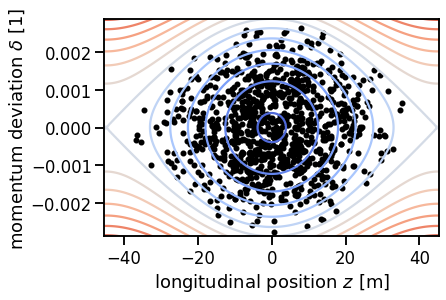

In [8]:
rfsystems = machine.longitudinal_map
rfbucket = rfsystems.get_bucket(bunch)

zz = np.linspace(*rfbucket.interval, num=1000)
dp_max = rfbucket.separatrix(0)
dpp = np.linspace(-dp_max*1.1, dp_max*1.1, num=100)
ZZ, DPP = np.meshgrid(zz, dpp)
HH = rfbucket.hamiltonian(ZZ, DPP)

plt.scatter(bunch.z, bunch.dp, marker='.', color='black')
plt.contour(ZZ, DPP, HH, 15, cmap=plt.get_cmap('coolwarm'))
plt.xlim(rfbucket.interval)
plt.ylim(-dp_max, dp_max)
plt.xlabel('longitudinal position $z$ [m]')
plt.ylabel('momentum deviation $\delta$ [1]');

The one turn map of the machine now includes 1 betatron tracking segment `TransverseSegmentMap` and the synchrotron tracking element `RFSystems`:

In [9]:
machine.one_turn_map

We are now ready to track the beam, simulating just the betatron motion. We will record the incoherent motion of the particles to show that they all move with the bare machine tune.

In [10]:
n_turns = 512

x_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
y_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)

For the tracking, we execute the loop over all turns and over the machine transverse elements, which are stored in `machine.transverse_map`.

In [11]:
for i in range(n_turns):
    for m in machine.transverse_map:
        x_rec[i, :] = bunch.x
        y_rec[i, :] = bunch.y
        m.track(bunch)

Let's plot one sample particle motion:

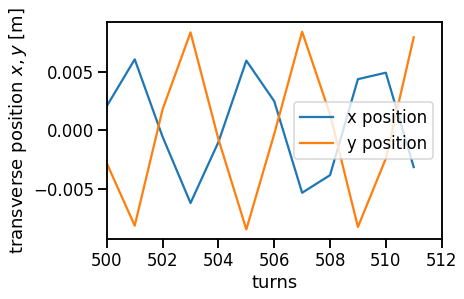

In [12]:
plt.plot(x_rec[:, 0], label='x position')
plt.plot(y_rec[:, 0], label='y position')
plt.legend()
plt.xlim(500, 512)
plt.xlabel('turns')
plt.ylabel('transverse position $x,y$ [m]');

The incoherent tune spectra only show the bare machine tune peak:

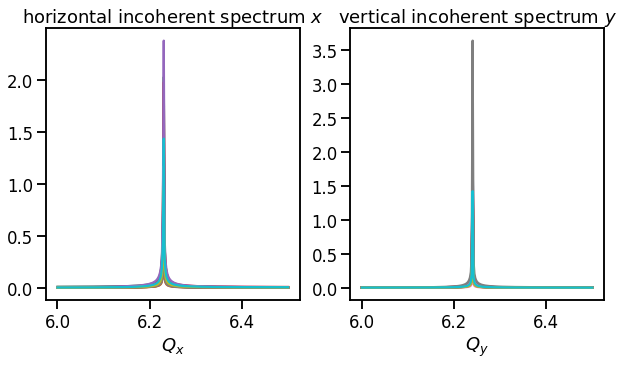

In [13]:
freqs = 6 + np.fft.rfftfreq(n_turns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for x, y in zip(x_rec.T[:20], y_rec.T[:20]):
    ax[0].plot(freqs, np.abs(np.fft.rfft(x)))
    ax[1].plot(freqs, np.abs(np.fft.rfft(y)))
ax[0].set_title('horizontal incoherent spectrum $x$')
ax[0].set_xlabel('$Q_x$')
ax[1].set_title('vertical incoherent spectrum $y$')
ax[1].set_xlabel('$Q_y$');

The entire one turn map of the machine currently holds the `RFSystems` and the `TransverseMapSegment` for both longitudinal and transverse tracking. We can therefore run the full 6D tracking including the synchrotron motion by simply calling `machine.track(bunch)`:

In [14]:
n_turns = 8192

z_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)

for i in range(n_turns):
    z_rec[i, :] = bunch.z
    machine.track(bunch)

Now the incoherent longitudinal spectrum will show the tune depression with synchrotron amplitude due to the radio-frequency bucket non-linearities (remember we chose `longitudinal_focusing='non-linear'`, one could also choose `'linear'`).

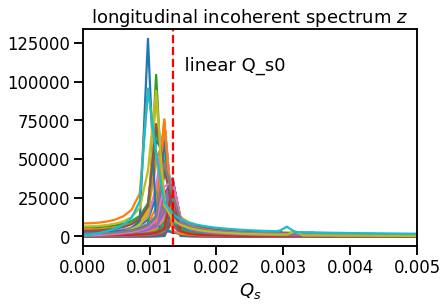

In [15]:
freqs = np.fft.rfftfreq(n_turns)
for z in z_rec.T[:50]:
    plt.plot(freqs, np.abs(np.fft.rfft(z)))
plt.xlim(0, 0.005);
plt.title('longitudinal incoherent spectrum $z$')
plt.axvline(rfbucket.Q_s, color='red', ls='--')
plt.text(rfbucket.Q_s, plt.ylim()[1]*0.8, '  linear Q_s0')
plt.xlabel('$Q_s$');

To add up to $n$th order chromaticity in the transverse plane, one can provide an $n$ entry vector as a keyword argument to the machine at `init` time:

In [16]:
Qp_x = [-0.83 * Q_x] # linear horizontal chromaticity, in tune units
Qp_y = [-1.12 * Q_y] # linear vertical chromaticity, in tune units

machine = PS(n_segments=1, gamma=gamma, machine_configuration='LHCbeam_h7', 
             longitudinal_focusing='non-linear', Q_x=Q_x, Q_y=Q_y, 
             # chromaticity enters here:
             Qp_x=Qp_x, Qp_y=Qp_y)

Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: gamma = 2.4921044947044524
Synchrotron init. From kwargs: machine_configuration = 'LHCbeam_h7'
Synchrotron init. From kwargs: Q_x = 6.23
Synchrotron init. From kwargs: Q_y = 6.24
Synchrotron init. From kwargs: Qp_x = [-5.1709000000000005]
Synchrotron init. From kwargs: Qp_y = [-6.988800000000001]


Generate another fresh bunch distribution:

In [17]:
# as before for the RF setup below transition energy:
machine.longitudinal_map.pop_kick(1)
machine.longitudinal_map.phi_offsets[0] += np.pi

bunch = machine.generate_6D_Gaussian_bunch_matched(
    n_macroparticles=n_macroparticles, intensity=intensity, 
    epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=sigma_z)

*** Maximum RMS bunch length 14.14653369562552m.


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


... distance to target bunch length: -1.2573e+01
... distance to target bunch length: 1.0562e+00
... distance to target bunch length: 9.8532e-01
... distance to target bunch length: -5.6875e-01
... distance to target bunch length: 4.1787e-01
... distance to target bunch length: 1.1448e-01
... distance to target bunch length: -8.8436e-03
... distance to target bunch length: 5.5485e-04
... distance to target bunch length: 2.5097e-06
... distance to target bunch length: -1.3242e-05
--> Bunch length: 12.700169347586202
--> Emittance: 1.2136287215403192


Repeating the 6D tracking exercise, ...

In [18]:
n_turns = 512

x_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
y_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)

for i in range(n_turns):
    x_rec[i, :] = bunch.x
    y_rec[i, :] = bunch.y
    machine.track(bunch)

... we now find the transverse tune spread around shifted tune values due to the linear chromaticity we plugged in:

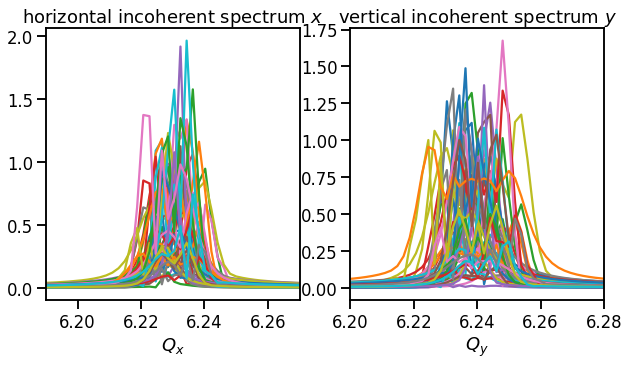

In [19]:
freqs = 6 + np.fft.rfftfreq(n_turns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for x, y in zip(x_rec.T[:50], y_rec.T[:50]):
    ax[0].plot(freqs, np.abs(np.fft.rfft(x)))
    ax[1].plot(freqs, np.abs(np.fft.rfft(y)))
ax[0].set_title('horizontal incoherent spectrum $x$')
ax[0].set_xlabel('$Q_x$')
ax[0].set_xlim(6.19, 6.27)
ax[1].set_title('vertical incoherent spectrum $y$')
ax[1].set_xlabel('$Q_y$')
ax[1].set_xlim(6.2, 6.28);

So far so good, you now know how to set up a basic tracking simulation. You may want to go ahead and have a look at further code examples in the playgrounds repository https://github.com/PyCOMPLETE/PyHEADTAIL-playground. There you'll find out how to tune up your PyHEADTAIL simulation with e.g.

- wakefield kicks for impedance-driven instability studies
- frozen / self-consistent space charge models for longitudinal, transverse or 3D studies
- apertures for loss studies
- multi-harmonic synchrotron motion for RF gymnastics (e.g. PS triple splitting)
- different longitudinal distributions
- synchrotron radiation
- transverse feedback
- an introduction to PyHEADTAIL on the GPU
- ...

to name just a few. And... never hesitate to have a look inside the source code of the modules. :-)

Best of success for your studies!